In [ ]:
!pip install wand

!apt install imagemagick

!pip install myqlm

!python -m qat.magics.install

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$ such that $$ \langle x | H | x \rangle = \sum_{i,j\in E} (1-2x_i)(1-2x_j)$$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0 # we compute the average value of H in the state |x>
    for edge in edges:
      i,j = edge
      val+= (1-2*b[i])*(1-2*b[j])
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

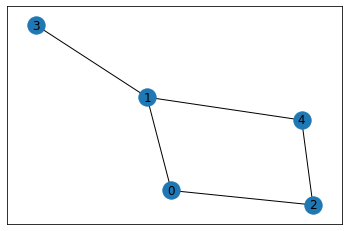

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z 
from scipy import linalg # for linalg.expm, the matrix exponential.


In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):
    
    layer = QRoutine()
    
    #TODO: implement one qaoa layer

    for i in range(n_qubits):
      layer.apply(RX(theta), i) #apply RX(theta) to all qubits
    for edge in edges:
      i,j = edge
      layer.apply(U_ZZ(beta), i,j) #apply exp(-i*beta*Hc) (the terms in Hc commute so it can be express as a product of U_ZZ applied to the pairs of qubits connected by an edge)
    
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    theta = parameters[::2]
    beta = parameters[1::2]

    for i in range(n_qubits): #initialization layer
      prog.apply(H, qubits[i])

    for i in range(len(theta)):
      prog.apply(one_qaoa_layer(n_qubits, edges, theta[i], beta[i]),qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0 # mean value of the observable that we want to minimize
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        b = sample.state.bitstring
        val = 0 # value in the current nqubits state 
        for edge in edges :
            i,j = edge
            val+= (1-2*int(b[i]))*(1-2*int(b[j]))
        obs += val * sample.probability # value in the nqubits state * the probability to get this state
    
    # END TODO
    return obs
    
        

In [ ]:
import numpy as np
np.random.random(3)

array([0.6927389 , 0.26091952, 0.11272053])

In [ ]:
from scipy.optimize import minimize
import matplotlib.pylab as plt


### Random initialisation

### Question 5: 
réponse à la question:

-2.0000284973979614 -2.8179066911623813 -3.0788882015471795 -3.4948138291086646 -3.8576045153891796 -3.959092214039797 -4.096627207163862 -4.32119025357856 -4.413563469935846 -4.506316909729299 -4.5948794298217015 -4.61517164788355 -4.646262104026609 -4.665801161904426 -4.675130169828214 -4.689981106881752 -4.705426946248778 -4.710792187454458 -4.717790987405076 -4.725561657359301 -4.730905836908511 -4.736322815893168 -4.742336209958647 -4.746704283500548 -4.750689512092331 -4.756646370256369 -4.762469276948718 -4.770120025419869 -4.775640637766215 -4.782515384937092 -4.786376363849802 -4.791569881121999 -4.7948288692761105 -4.800645858505836 -4.807643091366657 -4.818556171312809 -4.83371334578853 -4.847911956166981 -4.854411672216106 -4.863088636637331 -4.875557448404198 -4.885123002309353 -4.891775809451471 -4.8937790986487135 -4.896225248646208 -4.898229954011157 -4.899778202196003 -4.90193263786179 -4.903506659609369 -4.9049437162167004 -4.906837403225629 -4.9076886433720945 -4.909

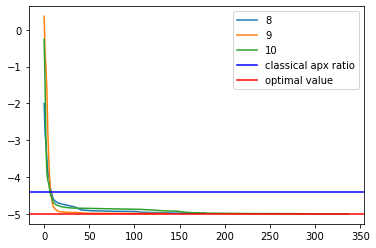

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.2644561491706523 -3.275129698433766 -3.5803536832777794 -3.944312280975691 -4.100940923174507 -4.247900961530721 -4.289617028048872 -4.334838251580709 -4.352872451684211 -4.4283774747537805 -4.467243477031029 -4.502966707474718 -4.510697862038829 -4.524215889310044 -4.542873577566443 -4.549564188766051 -4.55259993028272 -4.557173099702381 -4.564297260191622 -4.573796567125856 -4.582858142919883 -4.588760622516712 -4.596373817476005 -4.603627260567776 -4.609573438586914 -4.615127349118649 -4.616799463287659 -4.618274654914141 -4.61992104489367 -4.620329180947071 -4.620696501850683 -4.620754755973922 -4.62078386879976 -4.620786995178199 -4.620787637643042 -4.620787678345149 -4.620787683371776 -4.6207876840642355 -4.620787684120783 -2.9603925847150308 -3.7367228388124585 -4.155862611402541 -4.251214361317189 -4.3803989760122075 -4.42281431287218 -4.477133938998594 -4.526244497587388 -4.560330477762858 -4.606484988274348 -4.657276070924784 -4.669145854756268 -4.678287944973717 -4.682233

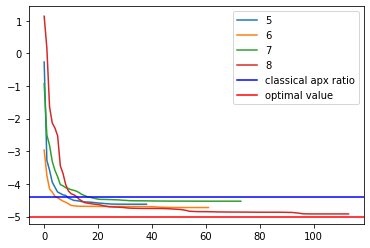

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(5,9,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.10204743840214456 -1.8662969945149368 -2.1025595813877223 -2.3781625631946777 -2.385595315259363 -2.3856106965335773 -2.3856107037391854 -2.0987423694643597 -3.2797758043291134 -3.686318420463405 -3.7998521363940423 -3.914236030204914 -3.960797343476867 -3.977819539518912 -3.9782044455318544 -3.978268605904336 -3.9782690130008262 -3.9782690296292604 -3.9782690296563805 -1.0409636642300677 -3.097294046362511 -3.793247879506475 -3.9264611888928926 -3.961494541916558 -3.999945649680145 -4.013262091028175 -4.027974951109314 -4.052256706247967 -4.077093570987131 -4.082009137258886 -4.090102529083466 -4.101479667892335 -4.112886270013382 -4.1303046123464835 -4.157036378570219 -4.197895717179589 -4.243207062760474 -4.26237503242642 -4.285247122965344 -4.324132731073188 -4.381191675707193 -4.409571632762844 -4.446429641361061 -4.459843004168901 -4.463283681978007 -4.463575253753364 -4.463825405943654 -4.463832079075271 -4.463832619359646 -4.463832631530129 -4.463832632295356 

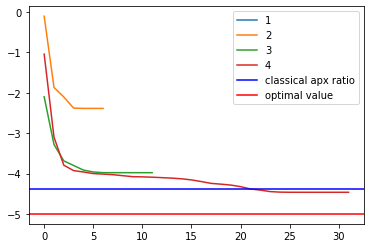

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(1,5,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

As expected, when we increase the number of layers, the number of iterations needed to converge increases too, because the number of parameters increases. We see that the optimal value is reached for about 9 or more layers (see plot 1 and 2).
A minimum of about 4 layers is necessary to at least do better than the classical algorithm (see plot 3).

### Question 6: smart initialization

$$ \int_0^T H(s)ds = \sum_{k=1}^p\frac{T}{p}(1-\frac{k}{p})\sum_i\sigma_x^i+\frac{T}{p}\frac{k}{p}H_C
$$ so 
$$|\psi_{final}⟩=\prod^p_{k=1} e^{i\frac{T}{p}(1-\frac{k}{p})\sum_i\sigma_x^i} e^{i\frac{T}{p}\frac{k}{p}H_C} |\psi_{0}⟩
$$

We identify the coefficents
$$ \theta_k =\frac{T}{p}(1-\frac{k}{p}) , \beta_k = T\frac{k}{p^2}
$$
with p the number of layers in QAOA.

-0.4360588928597728 -1.0472867163117299 -1.7064362177610881 -2.134944800414402 -2.7494318089614787 -3.1115488279657413 -3.1943664205267353 -3.2151618708039216 -3.253922221694688 -3.2803092363020494 -3.3199926607420367 -3.3846483288767177 -3.4860647353357224 -3.6164452025114495 -3.7640439454909833 -3.9615392919685273 -4.047159182485359 -4.11800043276573 -4.253281911306897 -4.342640346837073 -4.4015859230295264 -4.434913797323881 -4.482795021049347 -4.512318979090505 -4.519235816267175 -4.531307444651705 -4.553436764370522 -4.587211944671339 -4.617007753108922 -4.633841644707404 -4.66094530571759 -4.679029067131205 -4.685518425515919 -4.69440383099646 -4.70399913625856 -4.710546462818941 -4.720778751397944 -4.728272094043708 -4.731748119643022 -4.737560651134131 -4.7412362150987555 -4.745914221297728 -4.748343580952685 -4.7515621788186655 -4.754634983851202 -4.760004240764662 -4.769661836306116 -4.786154072602625 -4.812708267159246 -4.824598019101848 -4.844496353863893 -4.876018462865023

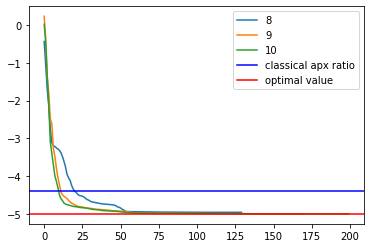

In [ ]:
T = 1.

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range(nlayers):
        parameters_init.append((1-i/nlayers)*T/nlayers)
        parameters_init.append(i/nlayers**2*T)
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.947000918786573 -3.0172982204170933 -3.2675019469312483 -3.668256461026599 -3.8285120574968503 -4.05358259350667 -4.108306113795008 -4.209532260688852 -4.379095400541442 -4.468641592528193 -4.505166525868157 -4.519400526945161 -4.540515174941514 -4.5546203057276795 -4.56113222962031 -4.569095341001851 -4.57688942551852 -4.587261465429836 -4.593093758521632 -4.601045175489955 -4.604478716155769 -4.607958202147123 -4.610901849670514 -4.614446283128416 -4.616176710334577 -4.617028841297027 -4.618314423024574 -4.620208979922589 -4.622847788127806 -4.626057567936629 -4.630363287263739 -4.6319217300922375 -4.632914953749139 -4.63346460663111 -4.633813939532607 -4.634363031519708 -4.635093477595395 -4.635585524032458 -4.6361349909933 -4.638006821057657 -4.638452927293546 -4.639300575274635 -4.640906675656602 -4.643700277028729 -4.647902942490944 -4.65406924630204 -4.661582649162714 -4.6747728853058454 -4.694563800104397 -4.718975967339683 -4.731261163342914 -4.744826728215545 -4.7494396468

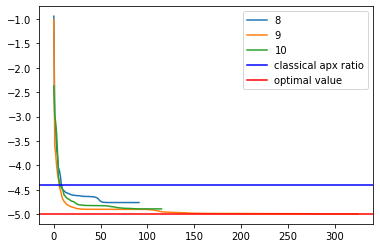

In [ ]:
T = 100.

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range(nlayers):
        parameters_init.append((1-i/nlayers)*T/nlayers)
        parameters_init.append(i/nlayers**2*T)
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-1.9079224252306102 -2.6312034140710496 -3.2430900605375483 -3.609344129394822 -4.061400870358233 -4.439873725068388 -4.529830344543361 -4.6119564775581035 -4.6960557479884395 -4.779550126155045 -4.817712719181864 -4.857163411037887 -4.867977582444557 -4.887076707865127 -4.9159061846725285 -4.932417671922833 -4.9431875519598725 -4.948550507870877 -4.953580584021546 -4.957043896886821 -4.957989458372526 -4.958427753482832 -4.958929047785294 -4.959343570883669 -4.959729571621488 -4.960175270140598 -4.960483987077007 -4.960968618969537 -4.961771842894833 -4.963047888420997 -4.963972423447411 -4.965277327017978 -4.966768998581984 -4.967378022063792 -4.9675246078216535 -4.967597634245497 -4.967703407294312 -4.967818225306393 -4.967872491983402 -4.967897273840417 -4.967913824694443 -4.967928980579921 -4.967939375899558 -4.967942769802437 -4.967945202095971 -4.967945525904275 -4.967945566089558 -4.967945570926662 -4.967945572011229 -4.967945572091912 -0.20922780838563834 -0.738706617183073 -0

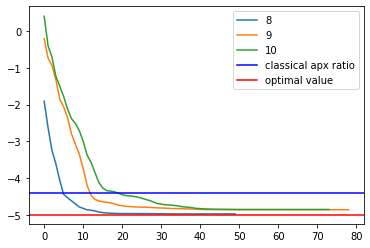

In [ ]:
T = 10000.

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range(nlayers):
        parameters_init.append((1-i/nlayers)*T/nlayers)
        parameters_init.append(i/nlayers**2*T)
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.1721598860327955 -0.5949640604371571 -0.8406023273034252 -1.1890412303101345 -1.3202665908718643 -2.414040274421631 -2.4794165946750173 -2.9735173964196453 -3.5781281357622707 -3.905406341064305 -4.068059037728977 -4.239535364091668 -4.264271066969926 -4.303218710688574 -4.355003708423423 -4.404557468214917 -4.448725504445431 -4.479112239630799 -4.513234404108201 -4.535331882094714 -4.549372620937587 -4.561204976946299 -4.580059416487809 -4.608226062074753 -4.621684383732879 -4.626206048179828 -4.633087889128051 -4.642577106340482 -4.655650606933905 -4.669347271321207 -4.683403618859063 -4.699389035157588 -4.703438141700306 -4.710216906111438 -4.712855939235726 -4.716344308100214 -4.719679640322137 -4.722086668887718 -4.725417343296433 -4.727542723692179 -4.729079442310543 -4.731393143849279 -4.734382016392764 -4.73703364182534 -4.740716296007838 -4.744875897730031 -4.748386512142174 -4.753575802091582 -4.75651606388603 -4.758499531652235 -4.760243655804895 -4.762631615198102 -4.764

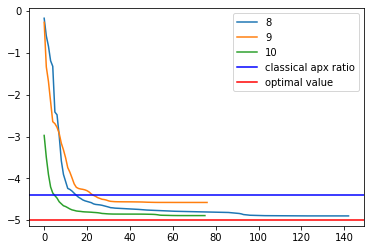

In [ ]:
T = 1000000.

for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for i in range(nlayers):
        parameters_init.append((1-i/nlayers)*T/nlayers)
        parameters_init.append(i/nlayers**2*T)
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

In question 5, if we look at the first plot, the algorithm needs around 150 iterations to converge. With the smart initialisation, the algorithm converges faster for the same numbers of layers (between 50 and 100 iterations most of the time). However, when T is increased, the algorithm does not always converge to the optimal value (it still stays better than the classical algorithm). The main hypothesis of AQC is that the transition is slow. If we increase T and we keep the same number of layers (equivalent to number of steps in AQC), at some point, the steps are too large and the transition is not slow anymore. In this case the initialization is not revelant anymore. It can explain the poor results with high T. The value of T must be adapted to the number of layers.